"IMPLEMENTASI MODEL RESNET PADA CITRA PENYAKIT DAUN DENGAN METODE JARINGAN SYARAF KONVOLUSIONAL (CNN)" oleh Muhammad Jafar Shodiq (21120116130052)

# Mengimport Library dan Mendefinisikan Variabel

In [0]:
#mengimport direktori dari google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#menghitung total waktu jalannya program
import time
total_time = time.time()

#mengabaikan peringatan
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

#membuat data latih dan data uji
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import os
import cv2
import numpy as np
import random as rn
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#membangun model
from tensorflow.python.keras.applications.resnet import ResNet50, ResNet101, ResNet152
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.python.keras import optimizers

#visualisasi dan pengujian
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix

Using TensorFlow backend.


In [0]:
Apple___Apple_scab_DIR = '/content/drive/My Drive/Dataset/plantdisease-tugasakhir/Apple___Apple_scab'
Apple___Black_rot_DIR = '/content/drive/My Drive/Dataset/plantdisease-tugasakhir/Apple___Black_rot'
Grape___Black_rot_DIR = '/content/drive/My Drive/Dataset/plantdisease-tugasakhir/Grape___Black_rot'
Grape___Esca_DIR = '/content/drive/My Drive/Dataset/plantdisease-tugasakhir/Grape___Esca_(Black_Measles)'
Grape___Leaf_blight_DIR = '/content/drive/My Drive/Dataset/plantdisease-tugasakhir/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
Potato___Early_blight_DIR = '/content/drive/My Drive/Dataset/plantdisease-tugasakhir/Potato___Early_blight'
Potato___Late_blight_DIR = '/content/drive/My Drive/Dataset/plantdisease-tugasakhir/Potato___Late_blight'
Tomato___Bacterial_spot_DIR = '/content/drive/My Drive/Dataset/plantdisease-tugasakhir/Tomato___Bacterial_spot'
Tomato___Septoria_leaf_spot_DIR = '/content/drive/My Drive/Dataset/plantdisease-tugasakhir/Tomato___Septoria_leaf_spot'
Tomato___Target_Spot_DIR = '/content/drive/My Drive/Dataset/plantdisease-tugasakhir/Tomato___Target_Spot'

X = []
Z = []

NUM_CLASSES = 10
CHANNELS = 3
IMG_SIZE = 224
BATCH_SIZE = 32
RANDOM_STATE = 42
NUM_EPOCHS = 20

RESNET_POOLING = 'avg'
RESNET_WEIGHTS = 'imagenet'
DENSE_LAYER_ACTIVATION = 'relu'
OUTPUT_DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'
LOSS_METRICS = ['accuracy']

#yang akan diubah-ubah
TEST_SIZE = 0.1
LEARNING_RATE = 0.01

# Membuat Data Latih dan Data Uji

In [0]:
def assign_label(img, plantdisease_type):
    return plantdisease_type
    
def make_train_data(plantdisease_type, DIR):
    for img in tqdm(os.listdir(DIR)): #tqdm untuk progress bar
        label = assign_label(img, plantdisease_type)
        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR) #membaca file gambar yang ada di masing-masing path
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) #mengubah ukuran gambar menjadi 224x224
        
        X.append(np.array(img)) #menambahkan dan mengubah gambar menjadi array
        Z.append(str(label)) #menambahkan kelas/kategori

In [0]:
#menghitung waktu
make_data_time = time.time()
#memproses data yang akan digunakan
make_train_data('Keropeng_Apel', Apple___Apple_scab_DIR)
print(len(X))
make_train_data('Busuk_Hitam_Apel', Apple___Black_rot_DIR)
print(len(X))
make_train_data('Busuk_Hitam_Anggur', Grape___Black_rot_DIR)
print(len(X))
make_train_data('Esca_Anggur', Grape___Esca_DIR)
print(len(X))
make_train_data('Hawar_Daun_Anggur', Grape___Leaf_blight_DIR)
print(len(X))
make_train_data('Bercak_Kering_Kentang', Potato___Early_blight_DIR)
print(len(X))
make_train_data('Hawar_Daun_Kentang', Potato___Late_blight_DIR)
print(len(X))
make_train_data('Bercak_Bakteri_Tomat', Tomato___Bacterial_spot_DIR)
print(len(X))
make_train_data('Bercak_Septoria_Tomat', Tomato___Septoria_leaf_spot_DIR)
print(len(X))
make_train_data('Bercak_Coklat_Tomat', Tomato___Target_Spot_DIR)
print(len(X))
make_data_time_spent = time.time()-make_data_time

  0%|          | 0/500 [00:00<?, ?it/s]

500


  0%|          | 0/500 [00:00<?, ?it/s]

1000


  0%|          | 0/500 [00:00<?, ?it/s]

1500


  0%|          | 0/500 [00:00<?, ?it/s]

2000


  0%|          | 0/500 [00:00<?, ?it/s]

2500


  0%|          | 0/500 [00:00<?, ?it/s]

3000


  0%|          | 0/500 [00:00<?, ?it/s]

3500


  0%|          | 0/500 [00:00<?, ?it/s]

4000


  0%|          | 0/500 [00:00<?, ?it/s]

4500


100%|██████████| 500/500 [04:18<00:00,  1.94it/s]

5000


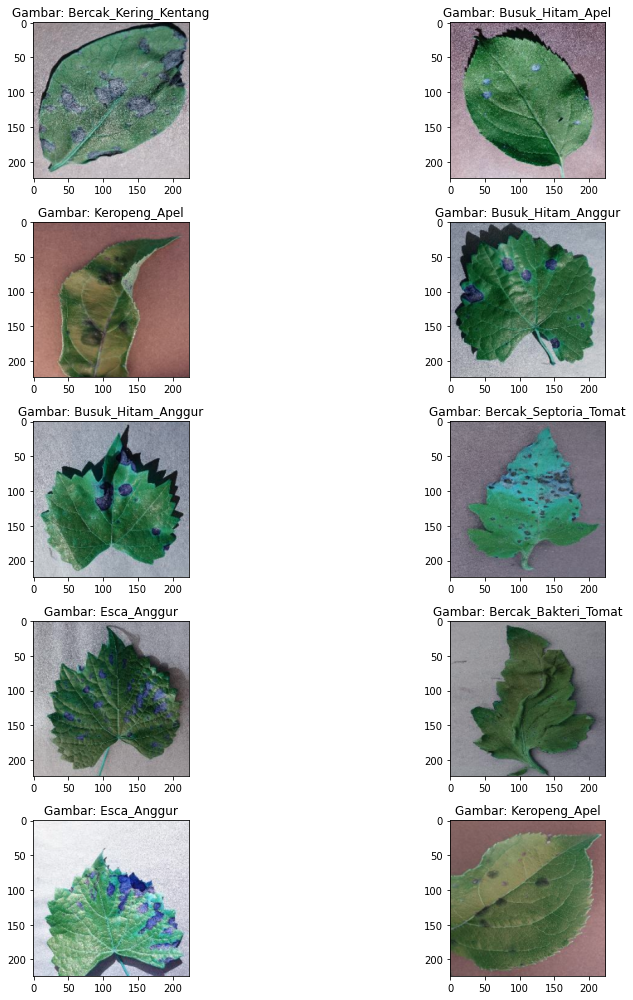

In [0]:
#menampilkan sampel secara acak
fig,ax = plt.subplots(5, 2)
fig.set_size_inches(14, 14)
for i in range(5):
    for j in range (2):
        l = rn.randint(0, len(Z))
        ax[i, j].imshow(X[l])
        ax[i, j].set_title('Gambar: '+Z[l])     
plt.tight_layout()

In [0]:
#mengubah kelas/kategori menjadi angka 0-9
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, NUM_CLASSES)
#normalisasi nilai piksel dengan membagi semua nilai dengan 255
X = np.array(X)
X = X/255

In [0]:
#membagi data menjadi data latih dan data uji
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = TEST_SIZE, random_state = RANDOM_STATE)

In [0]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4500, 224, 224, 3)
(4500, 10)
(500, 224, 224, 3)
(500, 10)


In [0]:
#menambahkan random seed
np.random.seed(RANDOM_STATE)
rn.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Membuat Model

In [0]:
#mengunduh model resnet
resnet_model = ResNet101(include_top=False, pooling=RESNET_POOLING, weights=RESNET_WEIGHTS, input_shape = (IMG_SIZE, IMG_SIZE, CHANNELS))

171450368/171446536 [==============================] - 4s 0us/step


In [0]:
#membangun model
model=Sequential()
model.add(resnet_model)
model.add(BatchNormalization())
model.add(Dense(256, activation = DENSE_LAYER_ACTIVATION))
model.add(BatchNormalization())
model.add(Dense(128, activation = DENSE_LAYER_ACTIVATION))
model.add(BatchNormalization())
model.add(Dense(64, activation = DENSE_LAYER_ACTIVATION))
model.add(BatchNormalization())
model.add(Dense(NUM_CLASSES, activation = OUTPUT_DENSE_LAYER_ACTIVATION))
#ResNet tidak perlu dilatih lagi karena sudah dilatih (pre-trained)
model.layers[0].trainable=False

In [0]:
#compile model
ADAM = tf.keras.optimizers.Adam(lr = LEARNING_RATE)
model.compile(optimizer = ADAM, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [0]:
#melihat lapisan, bentuk lapisan, dan jumlah parameter
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 2048)              42658176  
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8

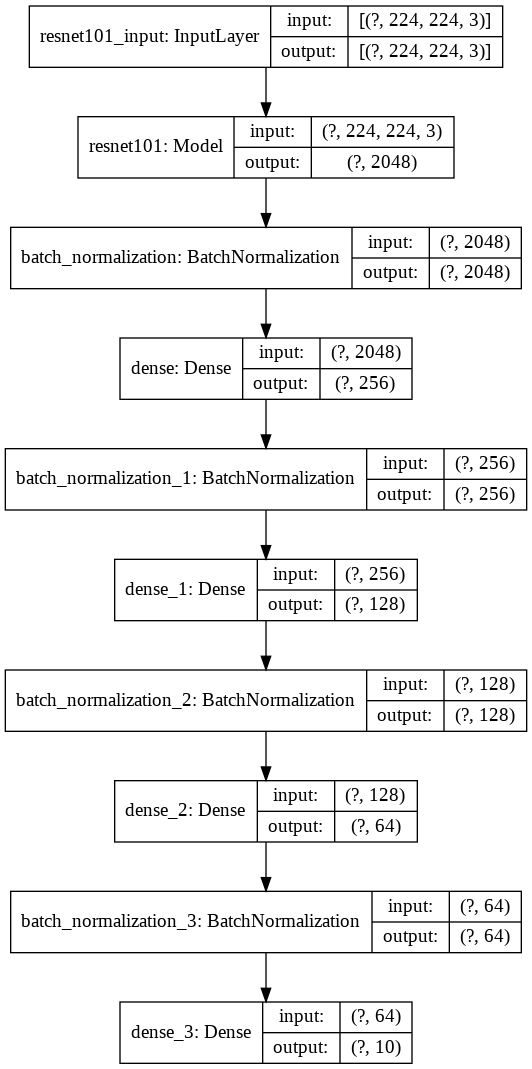

In [0]:
#menampilkan arsitektur model
keras.utils.plot_model(model, "model_architecture.png", show_shapes=True)

In [0]:
#menghitung waktu
train_time = time.time()
#melatih data
fit_history = model.fit(x_train, y_train,
                        epochs = NUM_EPOCHS,
                        batch_size = BATCH_SIZE,
                        validation_data = (x_test, y_test))
train_time_spent = time.time()-train_time

Epoch 1/20
141/141 [==============================] - 495s 4s/step - loss: 1.4393 - accuracy: 0.4976 - val_loss: 6.4527 - val_accuracy: 0.0940
Epoch 2/20
141/141 [==============================] - 490s 3s/step - loss: 0.9767 - accuracy: 0.6542 - val_loss: 3.2522 - val_accuracy: 0.1620
Epoch 3/20
141/141 [==============================] - 494s 4s/step - loss: 0.8151 - accuracy: 0.7140 - val_loss: 1.5502 - val_accuracy: 0.4700
Epoch 4/20
141/141 [==============================] - 492s 3s/step - loss: 0.7372 - accuracy: 0.7340 - val_loss: 1.2998 - val_accuracy: 0.5540
Epoch 5/20
141/141 [==============================] - 494s 4s/step - loss: 0.6643 - accuracy: 0.7627 - val_loss: 0.8773 - val_accuracy: 0.6940
Epoch 6/20
141/141 [==============================] - 492s 3s/step - loss: 0.6251 - accuracy: 0.7758 - val_loss: 1.8138 - val_accuracy: 0.5020
Epoch 7/20
141/141 [==============================] - 490s 3s/step - loss: 0.6219 - accuracy: 0.7771 - val_loss: 1.2596 - val_accuracy: 0.5980

In [0]:
#mengevaluasi hasil latih
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('Akurasi Data Uji:', test_acc)

16/16 - 46s - loss: 5.5837 - accuracy: 0.3220
Akurasi Data Uji: 0.32199999690055847


# Memvisualisasikan dan Menguji Model

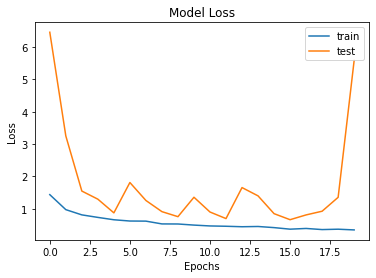

In [0]:
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

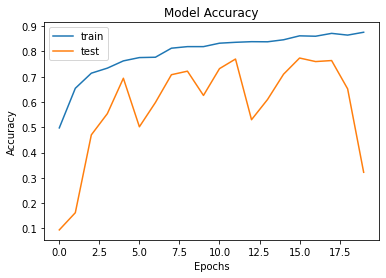

In [0]:
plt.plot(fit_history.history['accuracy'])
plt.plot(fit_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

                           precision    recall  f1-score   support

        (0) Keropeng_Apel       0.00      0.00      0.00        55
     (1) Busuk_Hitam_Apel       0.56      0.66      0.61        47
   (2) Busuk_Hitam_Anggur       0.71      0.74      0.73        54
          (3) Esca_Anggur       0.11      0.92      0.20        36
    (4) Hawar_Daun_Anggur       0.00      0.00      0.00        51
(5) Bercak_Kering_Kentang       0.83      0.09      0.17        54
   (6) Hawar_Daun_Kentang       0.62      0.45      0.53        44
 (7) Bercak_Bakteri_Tomat       0.65      0.61      0.63        51
(8) Bercak_Septoria_Tomat       1.00      0.02      0.04        45
  (9) Bercak_Coklat_Tomat       0.00      0.00      0.00        63

                 accuracy                           0.32       500
                macro avg       0.45      0.35      0.29       500
             weighted avg       0.44      0.32      0.28       500



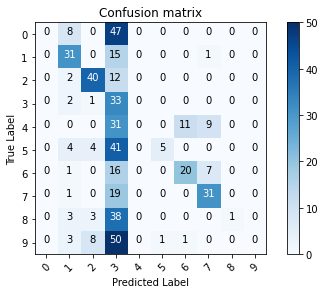

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

target_names=['(0) Keropeng_Apel',
              '(1) Busuk_Hitam_Apel',
              '(2) Busuk_Hitam_Anggur',
              '(3) Esca_Anggur',
              '(4) Hawar_Daun_Anggur',
              '(5) Bercak_Kering_Kentang',
              '(6) Hawar_Daun_Kentang',
              '(7) Bercak_Bakteri_Tomat',
              '(8) Bercak_Septoria_Tomat',
              '(9) Bercak_Coklat_Tomat']
Y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

plot_confusion_matrix(confusion_mtx, classes = range(NUM_CLASSES))
print(classification_report(Y_true, Y_pred_classes, target_names = target_names))

In [0]:
total_time_spent = time.time()-total_time

In [0]:
#total waktu jalannya program
print('Waktu untuk membuat data latih dan data uji:', make_data_time_spent)
print('Waktu untuk melatih data:', train_time_spent)
print('Total waktu keseluruhan:', total_time_spent)

Waktu untuk membuat data latih dan data uji: 2436.893807888031
Waktu untuk melatih data: 9990.214729309082
Total waktu keseluruhan: 12554.391273498535
